#  Lotka-Volterra with finite carrying capacity - nondimensionalized
*This Jupyter notebook presents the nondimensionalized form of __Lotka-Volterra model__  between two species, supposing both species have finite carrying capacity.*
Is is inspired by Strogatz's *Nonlinear Dynamics and Chaos* exercise 6.4.5 and 6.4.6, and the results can be compared with the work of  [**Baigent**](http://www.ucl.ac.uk/~ucess29/).

In [1]:
# Numerical package
import numpy as np

#Differential equation numerical solver
from scipy.integrate import odeint

# Import pyplot for plotting
import matplotlib.pyplot as plt

# To compute symbolic expressions
import sympy
# print outputs in LaTeX
sympy.init_printing(use_unicode=True) 

# Interactive manipulations in the notebook
#from ipywidgets import interact

# Magic function to make matplotlib inline
%matplotlib inline

# This enables SVG graphics inline.
%config InlineBackend.figure_formats = {'png', 'retina'}

%config InlineBackend.close_figures = False
# Suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Lotka-Volterra equations

Here we will study one of the classic models in biology: the Lotka-Volterra equations, with the use of symbolic and numeric computing with Python.

The coupled first-order non-linear differential equations are given by

\begin{align}
    \dot{N_1} &= r_1 N_1 \left( 1 - \frac{N_1}{K_1} - b_1 N_2 \right),\\[1em]
    \dot{N_2} &= r_2 N_2 \left( 1 - \frac{N_2}{K_2} - b_2 N_1 \right),
\end{align}

where
- $N_i$ = population size of species $i$
- $t$ = time
- $r_i$ = species $i$ growth rate
- $K_i$ = environment carrying capacity
- $b_1, \; b_2$ = inter-species competition parameters.

Note that in the absence of interspecific competition, each species grows to its respective carrying capacity. The relative sizes of $b_1, b_2 > 0$ determine the competitiveness of each species.

We will use it in a nondimensionalized form
\begin{align}
    \dot{x} &=  x \left( 1 - x - \beta_1 y \right),\\[1em]
    \dot{y} &= \rho y \left( 1 - y - \beta_2 x \right),
\end{align}


We will also try to address the same equation, but for a different model:  Mutualism
In this case each of the two species benefit from the presence of the other, so that the interaction terms change sign in the previous model to give
\begin{align}
    \dot{N_1} &= r_1 N_1 \left( 1 - \frac{N_1}{K_1} + b_1 N_2 \right),\\[1em]
    \dot{N_2} &= r_2 N_2 \left( 1 - \frac{N_2}{K_2} + b_2 N_1 \right),
\end{align}
or
\begin{align}
    \dot{x} &=  x \left( 1 - x + \beta_1 y \right),\\[1em]
    \dot{y} &= \rho y \left( 1 - y + \beta_2 x \right),
\end{align}
Usually in both model, we have the hypothesis that  $b_1, b_2 > 0$, our goal is to loosen this hypothesis in order to look at both models together.

## SymPy for Lotka-Volterra

To start working with `sympy` the first thing we have to do is to define the variables that we will use for our symbolic calculations.

In [2]:
# We split the definitions with the type of variables 
# r variables
r1, r2  = sympy.symbols('r_1 r_2', real=True)
# b variable
b1, b2 = sympy.symbols('b_1 b_2', real=True) #, positive=True
# K variable
K1, K2 = sympy.symbols('K_1 K_2', real=True, positive=True) # real=True

#function for species 1 and 2
N1, N2 = sympy.symbols('N_1 N_2', cls=sympy.Function) 

#temporal value
tau = sympy.symbols('tau')

We can now define the differential equations in sympy

In [3]:
diffeq1 = sympy.Eq(N1(tau).diff(tau),  r1 * N1(tau) *(1 - 1/K1*N1(tau) + b1*N2(tau)) )
diffeq2 = sympy.Eq(N2(tau).diff(tau),  r2 * N2(tau) *(1 - 1/K2*N2(tau) + b2*N1(tau)) )

And in the `IPython notebook` we can nicely display it as $\LaTeX$.

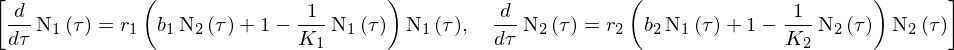

In [4]:
[diffeq1, diffeq2]

### Nondimensionalization

In [5]:
# a set of variables for nondimensionalization

#beta1, beta2= sympy.symbols('beta_1 beta_2')
beta1= sympy.symbols('beta_1', real=True ) #real=True, positive=True
beta2= sympy.symbols('beta_2', real=True)
rho = sympy.symbols('rho', real=True, positive=True)
x, y = sympy.symbols('x y', cls=sympy.Function) 
t, T = sympy.symbols('t T')

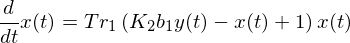

In [6]:
listSubs1=[(N1(tau).diff(tau), x(t).diff(t)/T*K1), (N1(tau), x(t)*K1), (N2(tau), y(t)*K2)]
NdDiffeq1=diffeq1.subs(listSubs1)
mult=T/K1
NdDiffeq1=sympy.simplify(sympy.Eq(sympy.Mul(NdDiffeq1.lhs,mult), sympy.Mul(NdDiffeq1.rhs,mult)))
NdDiffeq1

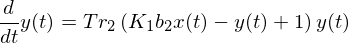

In [7]:
listSubs2=[(N2(tau).diff(tau), y(t).diff(t)/T*K2), (N2(tau), y(t)*K2), (N1(tau), x(t)*K1)]
NdDiffeq2=diffeq2.subs(listSubs2)
mult=T/K2
NdDiffeq2=sympy.simplify(sympy.Eq(sympy.Mul(NdDiffeq2.lhs,mult), sympy.Mul(NdDiffeq2.rhs,mult)))
NdDiffeq2

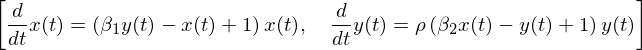

In [8]:
# fix parameters for nondimensionalization
listSubs=[(T, 1/r1), (b1, beta1/K2), (b2, beta2/K1), (r2, rho*r1)]
NdDiffeq1=sympy.simplify(NdDiffeq1.subs(listSubs))
NdDiffeq2=sympy.simplify(NdDiffeq2.subs(listSubs))

[NdDiffeq1,NdDiffeq2]

### Stationary states
Now we find the steady state, i.e. find when the derivative with respect to time equals to zero.

In [9]:
# set new time-independent variables
x, y = sympy.symbols('x y') 
listSubsVarib=[(x(t),x), (y(t),y) ]

NdDiffeq1.rhs.subs(listSubsVarib),NdDiffeq2.rhs.subs(listSubsVarib)

In [10]:
ss_x = sympy.Eq(NdDiffeq1.rhs.subs(listSubsVarib), 0)
ss_y = sympy.Eq(NdDiffeq2.rhs.subs(listSubsVarib), 0)
ss_x, ss_y

In [11]:
print('Nullclines:')
sympy.solve((ss_x),x), sympy.solve((ss_y),y)

Nullclines:


And now we just tell `sympy` to solve for the species population!

So we find that there are 4 steady state solution: the trivial solution in which both species are extinct, so $x = y = 0$,  two solutions, where only one population survives $(1,0)$ and $(0,1)$. Finally a solution in which both species maintain their non-zero populations.

The steady state solution for both species are:


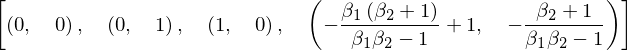

In [12]:
print('The steady state solution for both species are:')
ss_dict_xy = sympy.solve((ss_x, ss_y),(x, y), manual=True, simplify=True) #,force=True, simplify=False  particular=True
ss_dict_xy

### Jacobian

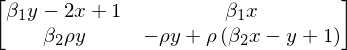

In [13]:
M=sympy.Matrix([ss_x.lhs, ss_y.lhs])
Jvar = sympy.Matrix([x, y])
J=M.jacobian(Jvar)
J

In [14]:
d2xy_dt2_num = sympy.utilities.lambdify([x, y, beta1, beta2, rho], J, ("math", "mpmath", "sympy"))

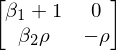

In [15]:
replacements = [(N, ss_dict_xy[1][i]) for i, N in enumerate([x, y])]
Jr=J.subs(replacements)
Jr

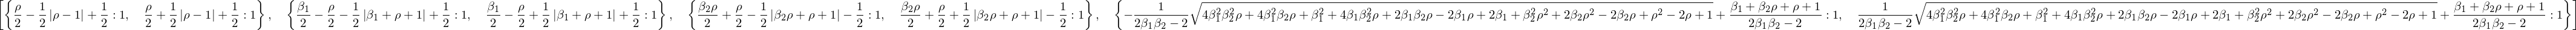

In [16]:
EigenVal = []
for ssSol in ss_dict_xy:
    replacements = []
    replacements = [(var, ssSol[i]) for i, var in enumerate([x, y])]
    EigenVal.append(J.subs(replacements).eigenvals()) #eigenvals
EigenVal

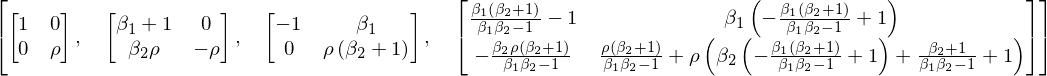

In [17]:
StStateMatrix = []
for ssSol in ss_dict_xy:
    replacements = []
    replacements = [(var, ssSol[i]) for i, var in enumerate([x, y])]
    StStateMatrix.append(J.subs(replacements)) #eigenvals
StStateMatrix

## Numerical simulation

In [18]:
ss_x, ss_y

In [19]:
# Generate 'lambdify' functions to numerically evaluate the diff. equations
dX_dt_numeric = sympy.utilities.lambdify([x, y, beta1, beta2, rho], [ss_x.lhs,ss_y.lhs], ("math", "mpmath", "sympy"))

In [20]:
def lotka_voltera_rhs(X, t, *p):
    '''
    Set up the right hand side (rhs) function for the system 
    (necessary step to feed sympy's odeint function).
    '''
    # unpack the parameters
    beta1, beta2, rho = p
    evald_dt=dX_dt_numeric(X[0],X[1], beta1, beta2, rho)
    
    
    return np.array([evald_dt[0], 
                    evald_dt[1]])

In [21]:
def lotka_voltera_gradient(X, t, *p):
    '''
    Set up the right hand side (rhs) function for the system 
    (necessary step to feed sympy's odeint function).
    '''
    # unpack the parameters
    beta1, beta2, rho = p
    evald_dt=d2xy_dt2_num(X[0],X[1], beta1, beta2, rho)
    
    return [  [evald_dt[0,0], evald_dt[0,1]],
              [evald_dt[1,0], evald_dt[1,1]]  ]

In [22]:
def plot_phase_plane(StartPoints, t, argsPar, xyMinMax, nb_points):

    values  = np.linspace(0.3, 0.9, len(StartPoints)) 

    f = plt.figure()
    # plot trajectories
    for point, v in zip(StartPoints, values): 
        X0 = point                     # starting point (internal)
        sol_n1n2 = odeint(lotka_voltera_rhs, np.transpose(X0), t, args=argsPar,Dfun=lotka_voltera_gradient, rtol=10.**-12)
        plt.plot( sol_n1n2[:,0], sol_n1n2[:,1], lw=v+1.5, color=plt.cm.autumn_r(v), label='(%.1f, %.1f)' % ( X0[0], X0[1]) )

    #-------------------------------------------------------
    # define a grid and compute direction at each point
    xmin = xyMinMax[0]
    xmax = xyMinMax[1]
    ymin = xyMinMax[2]
    ymax = xyMinMax[3] 

    xGrid = np.linspace(xmin, xmax, nb_points)
    yGrid = np.linspace(ymin, ymax, nb_points)
    X1 , Y1  = np.meshgrid(xGrid, yGrid)                       # create a grid
    DX1, DY1 = dX_dt_numeric(X1, Y1, argsPar[0], argsPar[1], argsPar[2])   # compute growth rate on the grid
    M = (np.hypot(DX1, DY1))                           # Norm of the growth rate 
    M[ M == 0] = 1.                                    # Avoid zero division errors 
    DX1 /= M                                           # Normalize each arrows
    DY1 /= M                                  
    #-------------------------------------------------------
    # Draw direction fields, using matplotlib 's quiver function
    Q = plt.quiver(X1, Y1, DX1, DY1, M, pivot='mid', cmap=plt.cm.jet)

    # Now find the nullclines.  Use matplotlib's contour routine to find the zero level.
    # We will need a fine mesh, reevaluate DX1 and DY1 on the finer grid, and use contour 
    # to find the level curves
    xGrid = np.linspace(xmin, xmax, nb_points*10)
    yGrid = np.linspace(ymin, ymax, nb_points*10)
    X1 , Y1  = np.meshgrid(xGrid, yGrid)                    
    dX1, dY1 = dX_dt_numeric(X1, Y1,  argsPar[0], argsPar[1], argsPar[2])
    plt.contour(X1, Y1, dX1, levels=[0], linewidths=3, colors='blue')
    plt.contour(X1, Y1, dY1, levels=[0], linewidths=3, colors='green')

    plt.legend(loc='best', fontsize=9)
    plt.grid()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    return f

### Competition
The competition case is when $\beta_i$ are negative.

#### Case I
$\beta_1<1$ and $\beta_2<1$

If the interspecific competition is not too strong the two populations can coexist stably, but at lower populations than their respective carrying capacities.

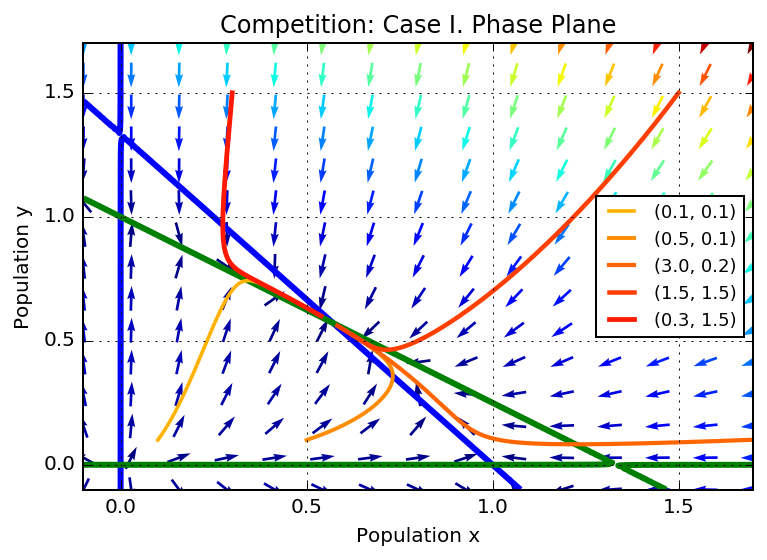

In [23]:
# let's set the parameter values.
beta = [-0.75, -0.75]
Rho = 2

argsPar = (beta[0], beta[1], Rho)

StartPoints = np.array([[0.1,0.1], [0.5,0.1], [3,0.2], [1.5,1.5], [0.3, 1.5]])
t = np.linspace(0, 15, 10000)
nb_points   = 15                      
xyMinMax=np.array([-0.1, 1.7, -0.1, 1.7 ])

f=plot_phase_plane(StartPoints, t, argsPar, xyMinMax, nb_points)
plt.title('Competition: Case I. Phase Plane')
plt.xlabel('Population x')
plt.ylabel('Population y')
f.savefig('OutImage/LV_Competition_CaseI.png')
f.canvas.draw()

#### Case II
$\beta_1>1$ and $\beta_2>1$

Interspecific competition is aggressive and ultimately one population wins, while the other is driven to extinction. The winner depends upon which has the starting advantage.

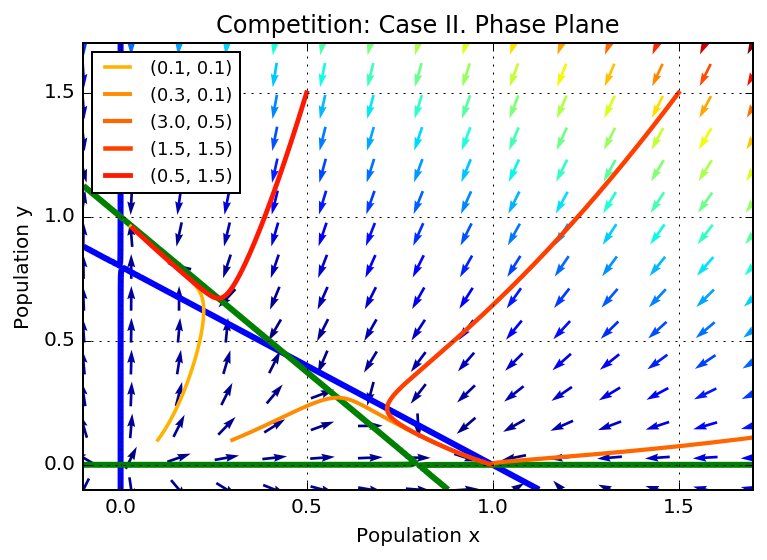

In [24]:
# let's set the parameter values.
beta = [-1.25, -1.25]
Rho = 2

argsPar = (beta[0], beta[1], Rho)

StartPoints = np.array([[0.1,0.1], [0.3,0.1], [3,0.5], [1.5,1.5], [0.5, 1.5]])
t = np.linspace(0, 15, 10000)
nb_points   = 15                      
xyMinMax=np.array([-0.1, 1.7, -0.1, 1.7 ])

f=plot_phase_plane(StartPoints, t, argsPar, xyMinMax, nb_points)
plt.title('Competition: Case II. Phase Plane')
plt.xlabel('Population x')
plt.ylabel('Population y')
f.savefig('OutImage/LV_Competition_CaseII.png')
f.canvas.draw()

#### Case III or IV
$\beta_1<1$ and $\beta_2>1$ or $\beta_1>1$ and $\beta_2<1$ 

Interspecific competition of one species dominates the other and, since the stable node in each case globally attracts
$R^2>0$, the species with the strongest competition always drives the other to extinction.

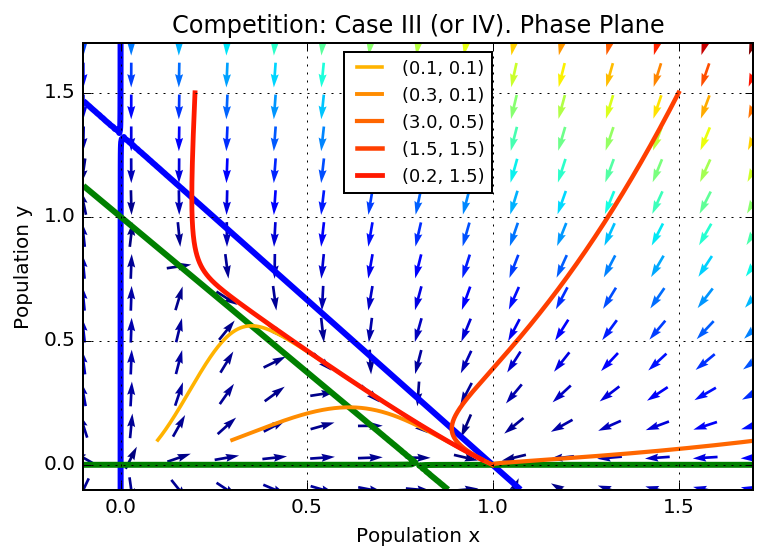

In [25]:
# let's set the parameter values.
beta = [-0.75, -1.25] #or beta = [-1.25, -0.75]
Rho = 2

argsPar = (beta[0], beta[1], Rho)

StartPoints = np.array([[0.1,0.1], [0.3,0.1], [3,0.5], [1.5,1.5], [0.2, 1.5]])
t = np.linspace(0, 15, 10000)
nb_points   = 15                      
xyMinMax=np.array([-0.1, 1.7, -0.1, 1.7 ])

f=plot_phase_plane(StartPoints, t, argsPar, xyMinMax, nb_points)
plt.title('Competition: Case III (or IV). Phase Plane')
plt.xlabel('Population x')
plt.ylabel('Population y')
f.savefig('OutImage/LV_Competition_CaseIII.png')
f.canvas.draw()

### Mutualism
In this case each of the two species benefit from the presence of the other; the interaction terms change sign in the previous model to give $\beta_i$ positive.

#### Case I
$\beta_1\cdot\beta_2<1$
In tis case, there is a non-zero steady state and all interior orbits converge to it.

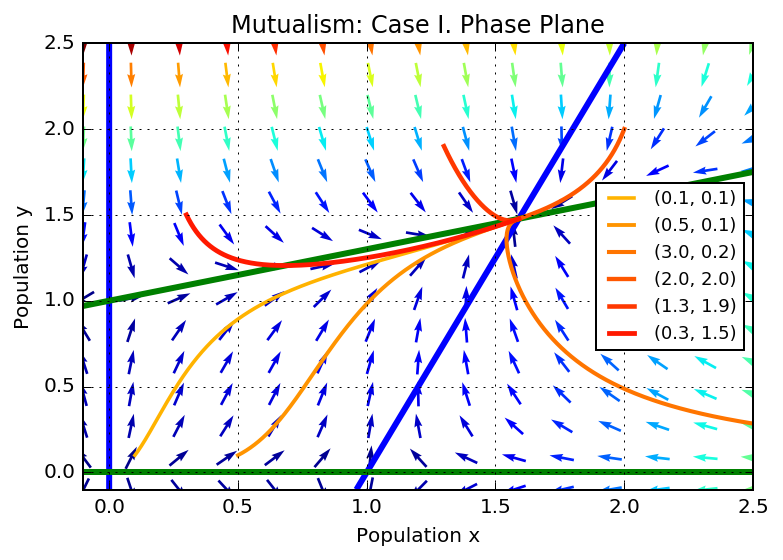

In [26]:
# let's set the parameter values.
beta = [0.4, 0.3]
Rho = 2

argsPar = (beta[0], beta[1], Rho)

StartPoints = np.array([[0.1,0.1], [0.5,0.1], [3,0.2], [2,2], [1.3,1.9], [0.3, 1.5] ])
t = np.linspace(0, 15, 10000)
nb_points   = 15                      
xyMinMax=np.array([-0.1, 2.5, -0.1, 2.5 ])

f=plot_phase_plane(StartPoints, t, argsPar, xyMinMax, nb_points)
plt.title('Mutualism: Case I. Phase Plane')
plt.xlabel('Population x')
plt.ylabel('Population y')
f.savefig('OutImage/LV_Mutualism_CaseI.png')
f.canvas.draw()

#### Case II
$\beta_1\cdot\beta_2>1$

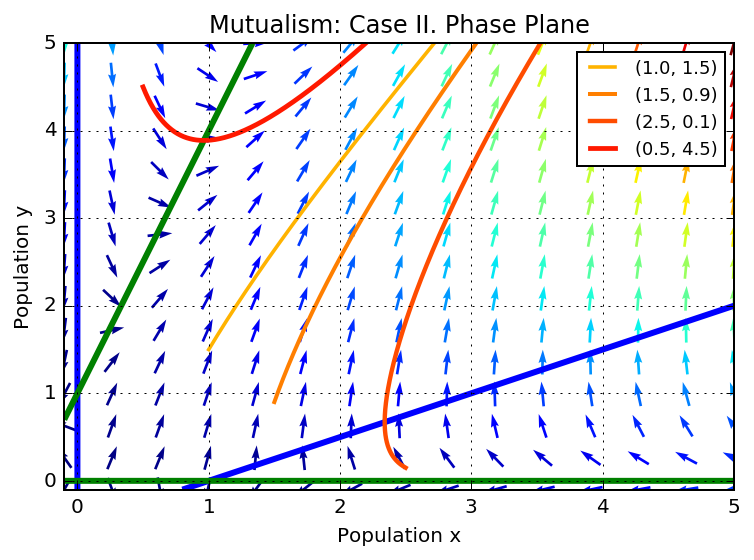

In [27]:
# let's set the parameter values.
beta = [2, 3]
Rho = 2

argsPar = (beta[0], beta[1], Rho)

StartPoints = np.array([[1,1.5],[1.5,0.9], [2.5,0.15], [0.5,4.5] ]) #[0.5,0.5],[1.5,0.9], [2.5,0.15], [0.2,4]
t = np.linspace(0, 0.3, 1000)
nb_points   = 15                      
xyMinMax=np.array([-0.1, 5, -0.1, 5 ])

f=plot_phase_plane(StartPoints, t, argsPar, xyMinMax, nb_points)
plt.title('Mutualism: Case II. Phase Plane')
plt.xlabel('Population x')
plt.ylabel('Population y')
f.savefig('OutImage/LV_Mutualism_CaseII.png')
f.canvas.draw()

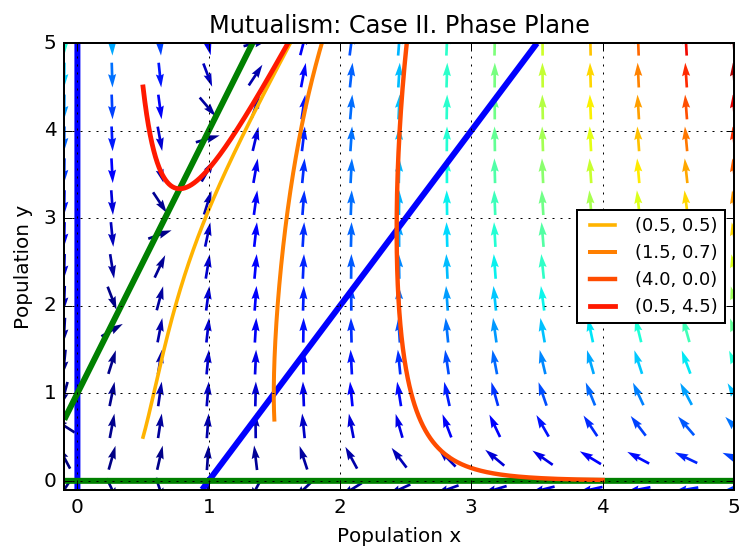

In [28]:
# let's set the parameter values.
beta = [0.5, 3]
Rho = 2

argsPar = (beta[0], beta[1], Rho)

StartPoints = np.array([[0.5,0.5],[1.5,0.7], [4,0.01], [0.5,4.5] ])
t = np.linspace(0, 1, 1000)
nb_points   = 15                      
xyMinMax=np.array([-0.1, 5, -0.1, 5 ])

f=plot_phase_plane(StartPoints, t, argsPar, xyMinMax, nb_points)
plt.title('Mutualism: Case II. Phase Plane')
plt.xlabel('Population x')
plt.ylabel('Population y')
f.savefig('OutImage/LV_Mutualism_CaseII_2.png')
f.canvas.draw()